<a href="https://colab.research.google.com/github/tingyushi/AI/blob/master/Image_Denoise/Image_Denoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application of neural network in denoising images

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset

## Dataset characteristics
The dataset used in this work may be found at (https://github.com/zalandoresearch/fashion-mnist).
A total of 60K images for training and 10K images for testing are available. Images are 28 x 28 pixels.

In our first three tasks, we will only use the first 5 classes from the dataset.

In [2]:
# Import first 5 classes from MNIST digit dataset
def importMnistDatasetFirstFiveClasses(train, transform=[]):
  # it will try to download the dataset if dataset is not found under the root directory
  dataset = torchvision.datasets.FashionMNIST(root='./data', train=train, download=True, transform=transform)
  idx = dataset.targets < 5
  dataset.targets = dataset.targets[idx]
  dataset.data = dataset.data[idx]

  return dataset

In [3]:
# Download datasets
train_set = importMnistDatasetFirstFiveClasses(train=True)
test_set = importMnistDatasetFirstFiveClasses(train=False)
print(train_set)
print(test_set)

100%|██████████| 26421880/26421880 [00:02<00:00, 10374794.51it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174784.63it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3281185.06it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22491955.20it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 30000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: []
Dataset FashionMNIST
    Number of datapoints: 5000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: []


In [4]:
# View names of the first 5 classe
train_set.classes[:5]

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat']

## Visualization of dataset and noise function

In [5]:
# To add noise to images, we can take advantage of the transform module.
# We have defined custom transform class Noise to add noise during image transformation
class Noise(object):
    # Here we create a noisy version of the data set
    # The way that we do it is we go over all the pixels of
    # each of the data points; then with probability p we multiply
    # the value of that pixel by 0 (making it essentially black).
    # Otherwise (with probability 1-p) we multiply the value of that
    # pixel by 1 (essentially keeping the pixel untouched)

    # drop_probability is basically the probability of dropping a pixel (p in the above)
    # This is how we create the noisy data set.
    # Convert image_set to a numpy array
    def __init__(self, drop_probability=0):
        self.drop_probability = drop_probability

    def __call__(self, tensor):
        n = torch.from_numpy(np.random.choice([0, 1], size=tensor.size(), p=[self.drop_probability, 1-self.drop_probability]))
        return tensor * n

    def __repr__(self):
        return self.__class__.__name__ + '(drop_probability={0})'.format(self.drop_probability)

# Return transform function to convert an image into a tensor.
# Add noise if drop_probability is provided.
def generateTransform(drop_probability):
  if drop_probability is not None and drop_probability > 0:
    trans_noise = transforms.Compose([
                              transforms.ToTensor(),
                              Noise(drop_probability)
                              ])
    return trans_noise
  else:
    return transforms.Compose([transforms.ToTensor()])

In [6]:
def show_gray_digits(image_set, row=2, col=3):
  # Here we visualize some of the data points in the data set.
  # Create a large figure, to be filled with multiple subplots.

  # Since image_set is a tensor variable, we transform it to a numpy type variable.
  image_set = image_set.cpu().detach().numpy()

  for i in range(row*col):
    # define subplot
    plt.subplot(row, col, i+1)
    # plot raw pixel data
    plt.imshow(image_set[i,0], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In the following we print some information about the data set. Then we will visualize some noisy digits.

In [7]:
# Load training dataset and add noise
train_set = importMnistDatasetFirstFiveClasses(train=True, transform=generateTransform(drop_probability=0.7))

# Add dataset to pytorch DataLoader with mini-batch size 64 s.t. each batch contains 64 images.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)

# Get first batch of images and labels
train_image_batch, classe_set = next(iter(train_loader))

first_image = train_image_batch[1]

print("For a single image, the data point shape is: ", first_image.shape)

print(f'train_loader contains {len(train_loader)} batches of data.')
print(f'train_image_batch has shape {train_image_batch.shape},')
print('where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image),\
 28X28 stands for WxH (width and height of a single image).')

For a single image, the data point shape is:  torch.Size([1, 28, 28])
train_loader contains 469 batches of data.
train_image_batch has shape torch.Size([64, 1, 28, 28]),
where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image), 28X28 stands for WxH (width and height of a single image).


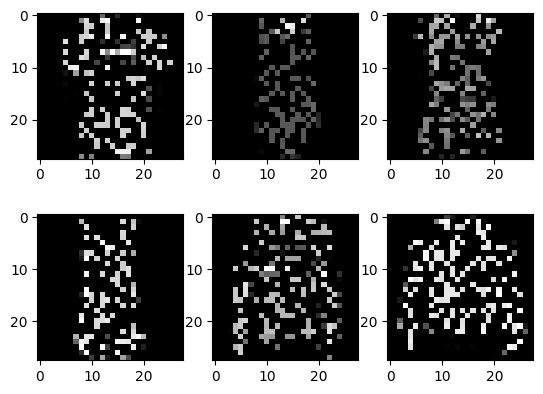

tensor([0, 0, 3, 0, 2, 2])


In [8]:
# display noised images and their corresponding labels.
show_gray_digits(train_image_batch, 2, 3)
print(classe_set[0:6])
del train_image_batch, classe_set, train_set, train_loader

## Create Dataloader
 Each training point consists of the input (noisy image) and the expected output (true image). We will create pytorch dataloaders such that every element of the data loader is a pair of true image and noisy image. Also, we will use only a small portion of the training data to make the task more challenging.

In [9]:
# Function to create data loaders given the batch size
# Drop_probablity is used to control noise level
# importFunc accepts function as value
def load_data(batch_size, drop_probability=0.7, importFunc=importMnistDatasetFirstFiveClasses):
  # Import MNIST train and test datasets.
  # Import train set without adding noise.
  train_set = importFunc(train=True, transform=generateTransform(0))

  # Use only the first 800 points for training
  train_set = torch.utils.data.Subset(train_set, list(range(1, 800))) # without noise

  # Import train set and add noise.
  train_set_noise = importFunc(train=True, transform=generateTransform(drop_probability))

  # Use only the first 800 points for training
  train_set_noise = torch.utils.data.Subset(train_set_noise, list(range(1, 800)))  #with noise

  # Load the first 1000 points of test dataset
  test_set = importFunc(train=False, transform=generateTransform(0))
  test_set = torch.utils.data.Subset(test_set, list(range(1, 1000)))  # without noise
  test_set_noise = importFunc(train=False, transform=generateTransform(drop_probability))
  test_set_noise = torch.utils.data.Subset(test_set_noise, list(range(1, 1000))) # with noise

  # Create a new dataset storing image pairs,
  # an item in the dataset is a pair of images (original and noised).
  train_set = PairDataset(train_set, train_set_noise)
  test_set = PairDataset(test_set, test_set_noise)

  # Generate train and test dataloaders,
  # Dataloader is used to loop through data batches.
  # !!! the data in two loaders are paried
  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

  return train_loader, test_loader

# When get an item from the dataset, it returns a pair of data.
# In our case, it returns image and corresponding noised image.
class PairDataset(Dataset):
    def __init__(self, dataset_origin, dataset_noisy):
        self.dataset_origin = dataset_origin
        self.dataset_noisy = dataset_noisy

    def __getitem__(self, index):
        x1 = self.dataset_origin[index]
        x2 = self.dataset_noisy[index]
        return x1, x2

    def __len__(self):
        return len(self.dataset_origin)

Let us load all the data.


In [10]:
# Load train and test data.
train_loader, test_loader = load_data(batch_size=64)
print(f'train_loader has {len(train_loader)} batches')
print(f'test_loader has {len(test_loader)} batches')

train_loader has 13 batches
test_loader has 16 batches


In [11]:
# print(np.ceil(800/64)) #13
# print(np.ceil(5000/64)) #79

Let us visualize images in each dataloader.

train


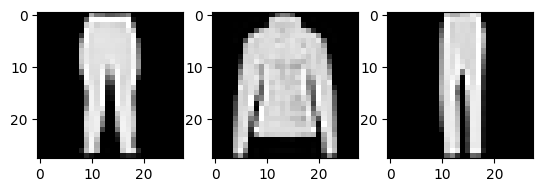

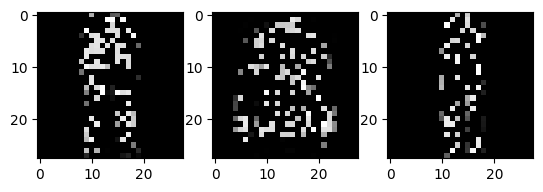

test


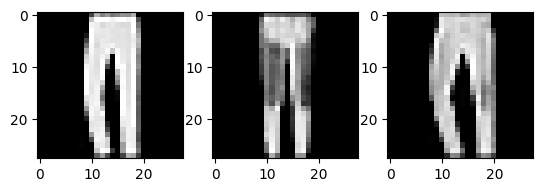

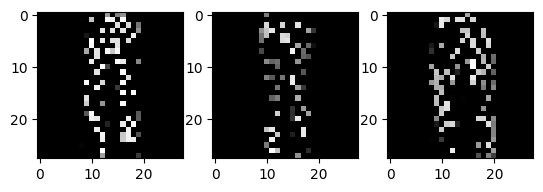

In [12]:
# Get a batch of images from each dataloader
train_image_batch, train_noise_image_batch = next(iter(train_loader))
test_image_batch, test_noise_image_batch = next(iter(test_loader))

# Show the first 3 image pairs
print('train')
show_gray_digits(train_image_batch[0], row=1, col=3)
show_gray_digits(train_noise_image_batch[0], 1, 3)
print('test')
show_gray_digits(test_image_batch[0], 1, 3)
show_gray_digits(test_noise_image_batch[0], 1, 3)
del train_loader, test_loader, train_image_batch, test_image_batch, train_noise_image_batch, test_noise_image_batch

## Image denoising using MLP


Network Characteristics
*  two fully connected layers
*  first layer: nn.Linear(28*28, 1000)
*  second layer: nn.Linear(1000, 28*28)
*  ReLU activation






In [13]:
class MyNeuralNetRegressor(nn.Module):
  # We create a neural network with 1 hidden layers with 1000 neurons,
  # and an output layer with 784 neurons (to match the dimension of our images!)
    def __init__(self):
        super(MyNeuralNetRegressor, self).__init__()

        self.l1 = nn.Linear(28 * 28, 1000)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(1000, 28 * 28)
        self.relu2 = nn.ReLU()


    def forward(self, x):
        # flatten the image
        x = x.view(-1, 28*28)

        x = self.l1(x)
        x = self.relu1(x)
        x = self.l2(x)
        x = self.relu2(x)

        # unflatten the image
        x = x.view(x.shape[0],1,28,28)
        return x

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


Hyperparameters:
* epochs=50
* learning_rate=0.05
* optimizer = optim.Adam(NeuralNet.parameters(), lr=learning_rate)
* batch_size=64
* loss_function = nn.L1Loss()

In [14]:
def train(train_loader, test_loader, model, epochs, loss_function, optimizer):
  # Lists to store train and test loss of epoches
  train_loss_epochs = []
  test_loss_epochs = []

  # set model to device
  model.to(device)

  # loop over the entire dataset #epochs times
  for epoch in range(epochs):
    print(f"epoch {epoch}")

    # List to store train loss of batches
    train_loss_batches = []

    for train_image_batch, train_noise_image_batch in iter(train_loader):
      # set model to training mode
      model.train()

      # get data points for images with/without noise
      trainImage = train_image_batch[0].to(device)
      trainNoiseImage = train_noise_image_batch[0].to(device)

      # calculate loss
      y = trainImage
      yhat = model(trainNoiseImage)
      loss = loss_function(y, yhat)

      # backward
      loss.backward()

      #optimization
      optimizer.step()
      optimizer.zero_grad()

      #append loss
      train_loss_batches.append(loss.item())

    # obtain average batch test loss
    test_loss_batch = test(test_loader, model, loss_function)

    train_loss_epochs.append(np.mean(train_loss_batches))
    test_loss_epochs.append(test_loss_batch)

  return train_loss_epochs, test_loss_epochs

# This is our test function. We pass all the testing data
# through the Network and compute the loss.
# Returns average batch test loss.
def test(dataloader, model, loss_function):
  # List to store test loss of batches.
  test_loss_batches = []

  model.to(device)

  # Set model to eval mode.
  model.eval()

  with torch.no_grad():
    for image_batch, noise_image_batch in iter(dataloader):

      # extract image
      images = image_batch[0].to(device)
      imagesNoise = noise_image_batch[0].to(device)

      # get y and yhat
      y = images
      yhat = model(imagesNoise)

      # calculate loss
      loss = loss_function(y, yhat)

      # append loss
      test_loss_batches.append(loss.item())

  return np.mean(test_loss_batches)

Load train and test data by calling load_data function with drop_probability=0.7. Train MyNeuralNetRegressor to denoise images. Report the train and test loss of the last epoch.

In [15]:
# Create a fresh model named model_task1
model_task1 = MyNeuralNetRegressor()

# Define L1 loss function
LossFunction = nn.L1Loss()

# Load train and test data
train_loader, test_loader = load_data(batch_size=64)

# Define optimizer for learning weights(parameters).
# Adam and SGD are two commonly used optimizers.
# We use Adam here.
learning_rate = 0.05
OPT = optim.Adam(model_task1.parameters(), lr=learning_rate)

# Define epochs
EP = 50

# Train the model
train_loss_epochs, test_loss_epochs = train(train_loader,
                                            test_loader,
                                            model_task1,
                                            EP,
                                            LossFunction,
                                            OPT)

MLPTrainLoss = train_loss_epochs
MLPTestLoss = test_loss_epochs

print(f'The train loss of the last epoch is {train_loss_epochs[-1]}')
print(f'The test loss of the last epoch is {test_loss_epochs[-1]}')


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
The train loss of the last epoch is 0.13006915438633698
The test loss of the last epoch is 0.13159517757594585


Plot the loss

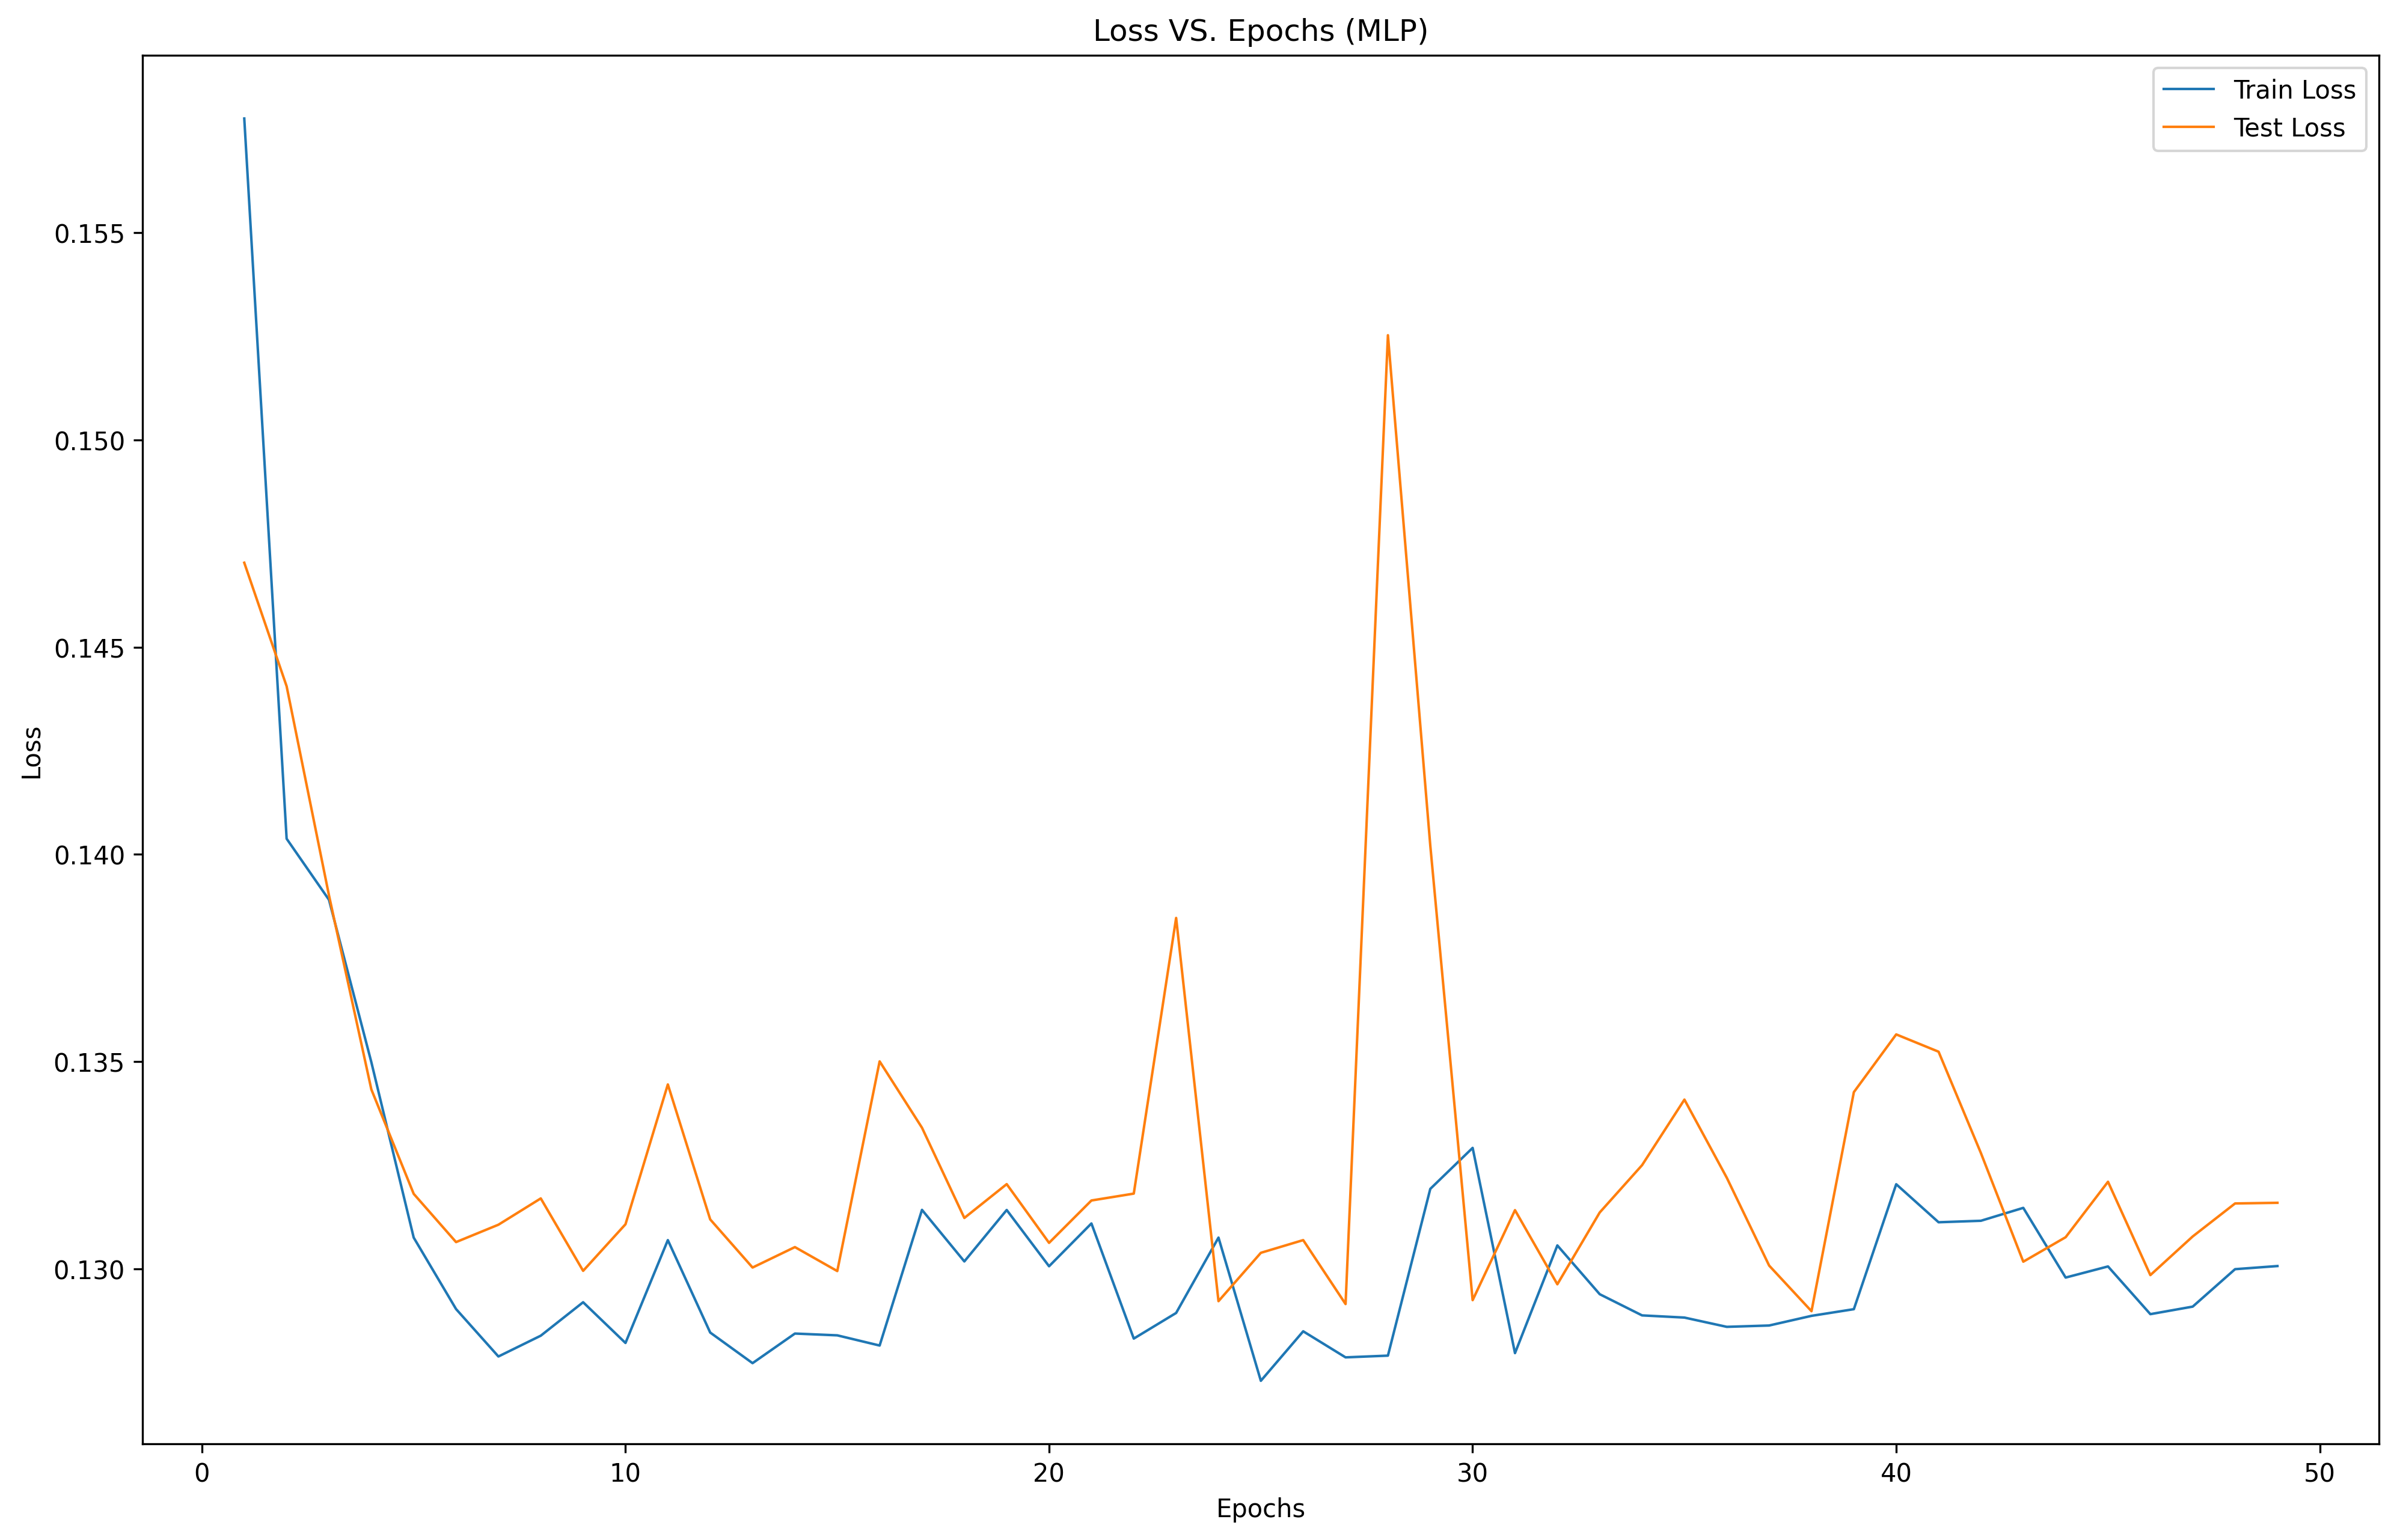

In [16]:
def plot_eval_results(train_loss_epochs, test_loss_epochs, graphTitle):
  EPList = [i for i in range(1, EP)]
  plt.plot(EPList , train_loss_epochs, linewidth=1.0 , label = "Train Loss")
  plt.plot(EPList , test_loss_epochs, linewidth=1.0 , label = "Test Loss")
  plt.legend()
  plt.xlabel("Epochs") ; plt.ylabel("Loss")
  plt.title(graphTitle)
  plt.gcf().set_size_inches(16, 10)
  plt.gcf().set_dpi(300)

title = "Loss VS. Epochs (MLP)"
plot_eval_results(train_loss_epochs[1:], test_loss_epochs[1:], title)

Number of parameters in the model

In [17]:
def getNumberOfParameters(model):
  counter = 0
  allParameters = model.parameters()
  for param in allParameters:
    counter += param.numel()
  return counter

print("MyNeuralNetRegressor has " + str(getNumberOfParameters(model_task1)) + " parameters")

MyNeuralNetRegressor has 1569784 parameters


## Image denoising using CNN


CNN Model characteristics:

*  two conv layers
*  first layer: *nn.Conv2d(in_channels=1, out_channels=10,kernel_size=3, padding=1, stride=1)*
*  second layer: *nn.Conv2d(in_channels=10, out_channels=1,kernel_size=3, padding=1, stride=1)
* ReLU activation function

In [18]:
class MyCNN(nn.Module):
  # We create a 2 layers CNN.
  # First conv is configured with filters(kernels) size 3, padding 1, and stride 1.
  # The first conv's inputs are images in dimension 28*28*1 (W*H*1).
  # Its output is in dimension 28*28*10 (W1*H1*num_feature_maps), where
      # W1=(W-Filter+2*Padding)/Stride+1 => 28=(28-3+2)/1+1.
      # H1=(H-Filter+2*Padding)/Stride+1 => 28=(28-3+2)/1+1.
  # Apply ReLU to the first conv output.
  # Pass the result as input to the second conv layer.
  # The second conv is configured with padding 1 and stride 1.
  # It outputs denoised images (dimension 28*28*1).

    def __init__(self):
        super(MyCNN, self).__init__()

        inputSize = 1
        hiddenSize = 10
        outputSize = 1

        self.cnn1 = nn.Conv2d(in_channels=inputSize,
                              out_channels=hiddenSize,
                              kernel_size=(3, 3), padding=1, stride=1)

        self.relu1 = nn.ReLU()

        self.cnn2 = nn.Conv2d(in_channels=hiddenSize,
                              out_channels=outputSize,
                              kernel_size=(3, 3), padding=1, stride=1)

        self.relu2 = nn.ReLU()


    def forward(self, x):
      x = self.cnn1(x)
      x = self.relu1(x)
      x = self.cnn2(x)
      x = self.relu2(x)
      return x


Model Hyperparameters:
* epochs=50
* learning_rate=0.05
* optimizer = optim.Adam(NeuralNet.parameters(), lr=learning_rate)
* batch_size=64
*loss_function = nn.L1Loss()


In [19]:
# name the CNN model model_task2
model_task2 = MyCNN()

Load train and test data by calling load_data function with drop_probability=0.7. Train MyCNN to denoise images. Report the train and test loss of the last epoch.

In [20]:
# Define L1 loss function
LossFunction = nn.L1Loss()

# Load train and test data
train_loader, test_loader = load_data(batch_size=64)

# Define optimizer for learning weights(parameters).
# Adam and SGD are two commonly used optimizers.
# We use Adam here.
learning_rate = 0.05
OPT = optim.Adam(model_task2.parameters(), lr=learning_rate)

# Define epochs
EP = 50

# Train the model
train_loss_epochs, test_loss_epochs = train(train_loader,
                                            test_loader,
                                            model_task2,
                                            EP,
                                            LossFunction,
                                            OPT)

CNNTrainLoss = train_loss_epochs
CNNTestLoss = test_loss_epochs

print(f'The train loss of the last epoch is {train_loss_epochs[-1]}')
print(f'The test loss of the last epoch is {test_loss_epochs[-1]}')

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
The train loss of the last epoch is 0.08358986733051446
The test loss of the last epoch is 0.08687750017270446


Plot Loss

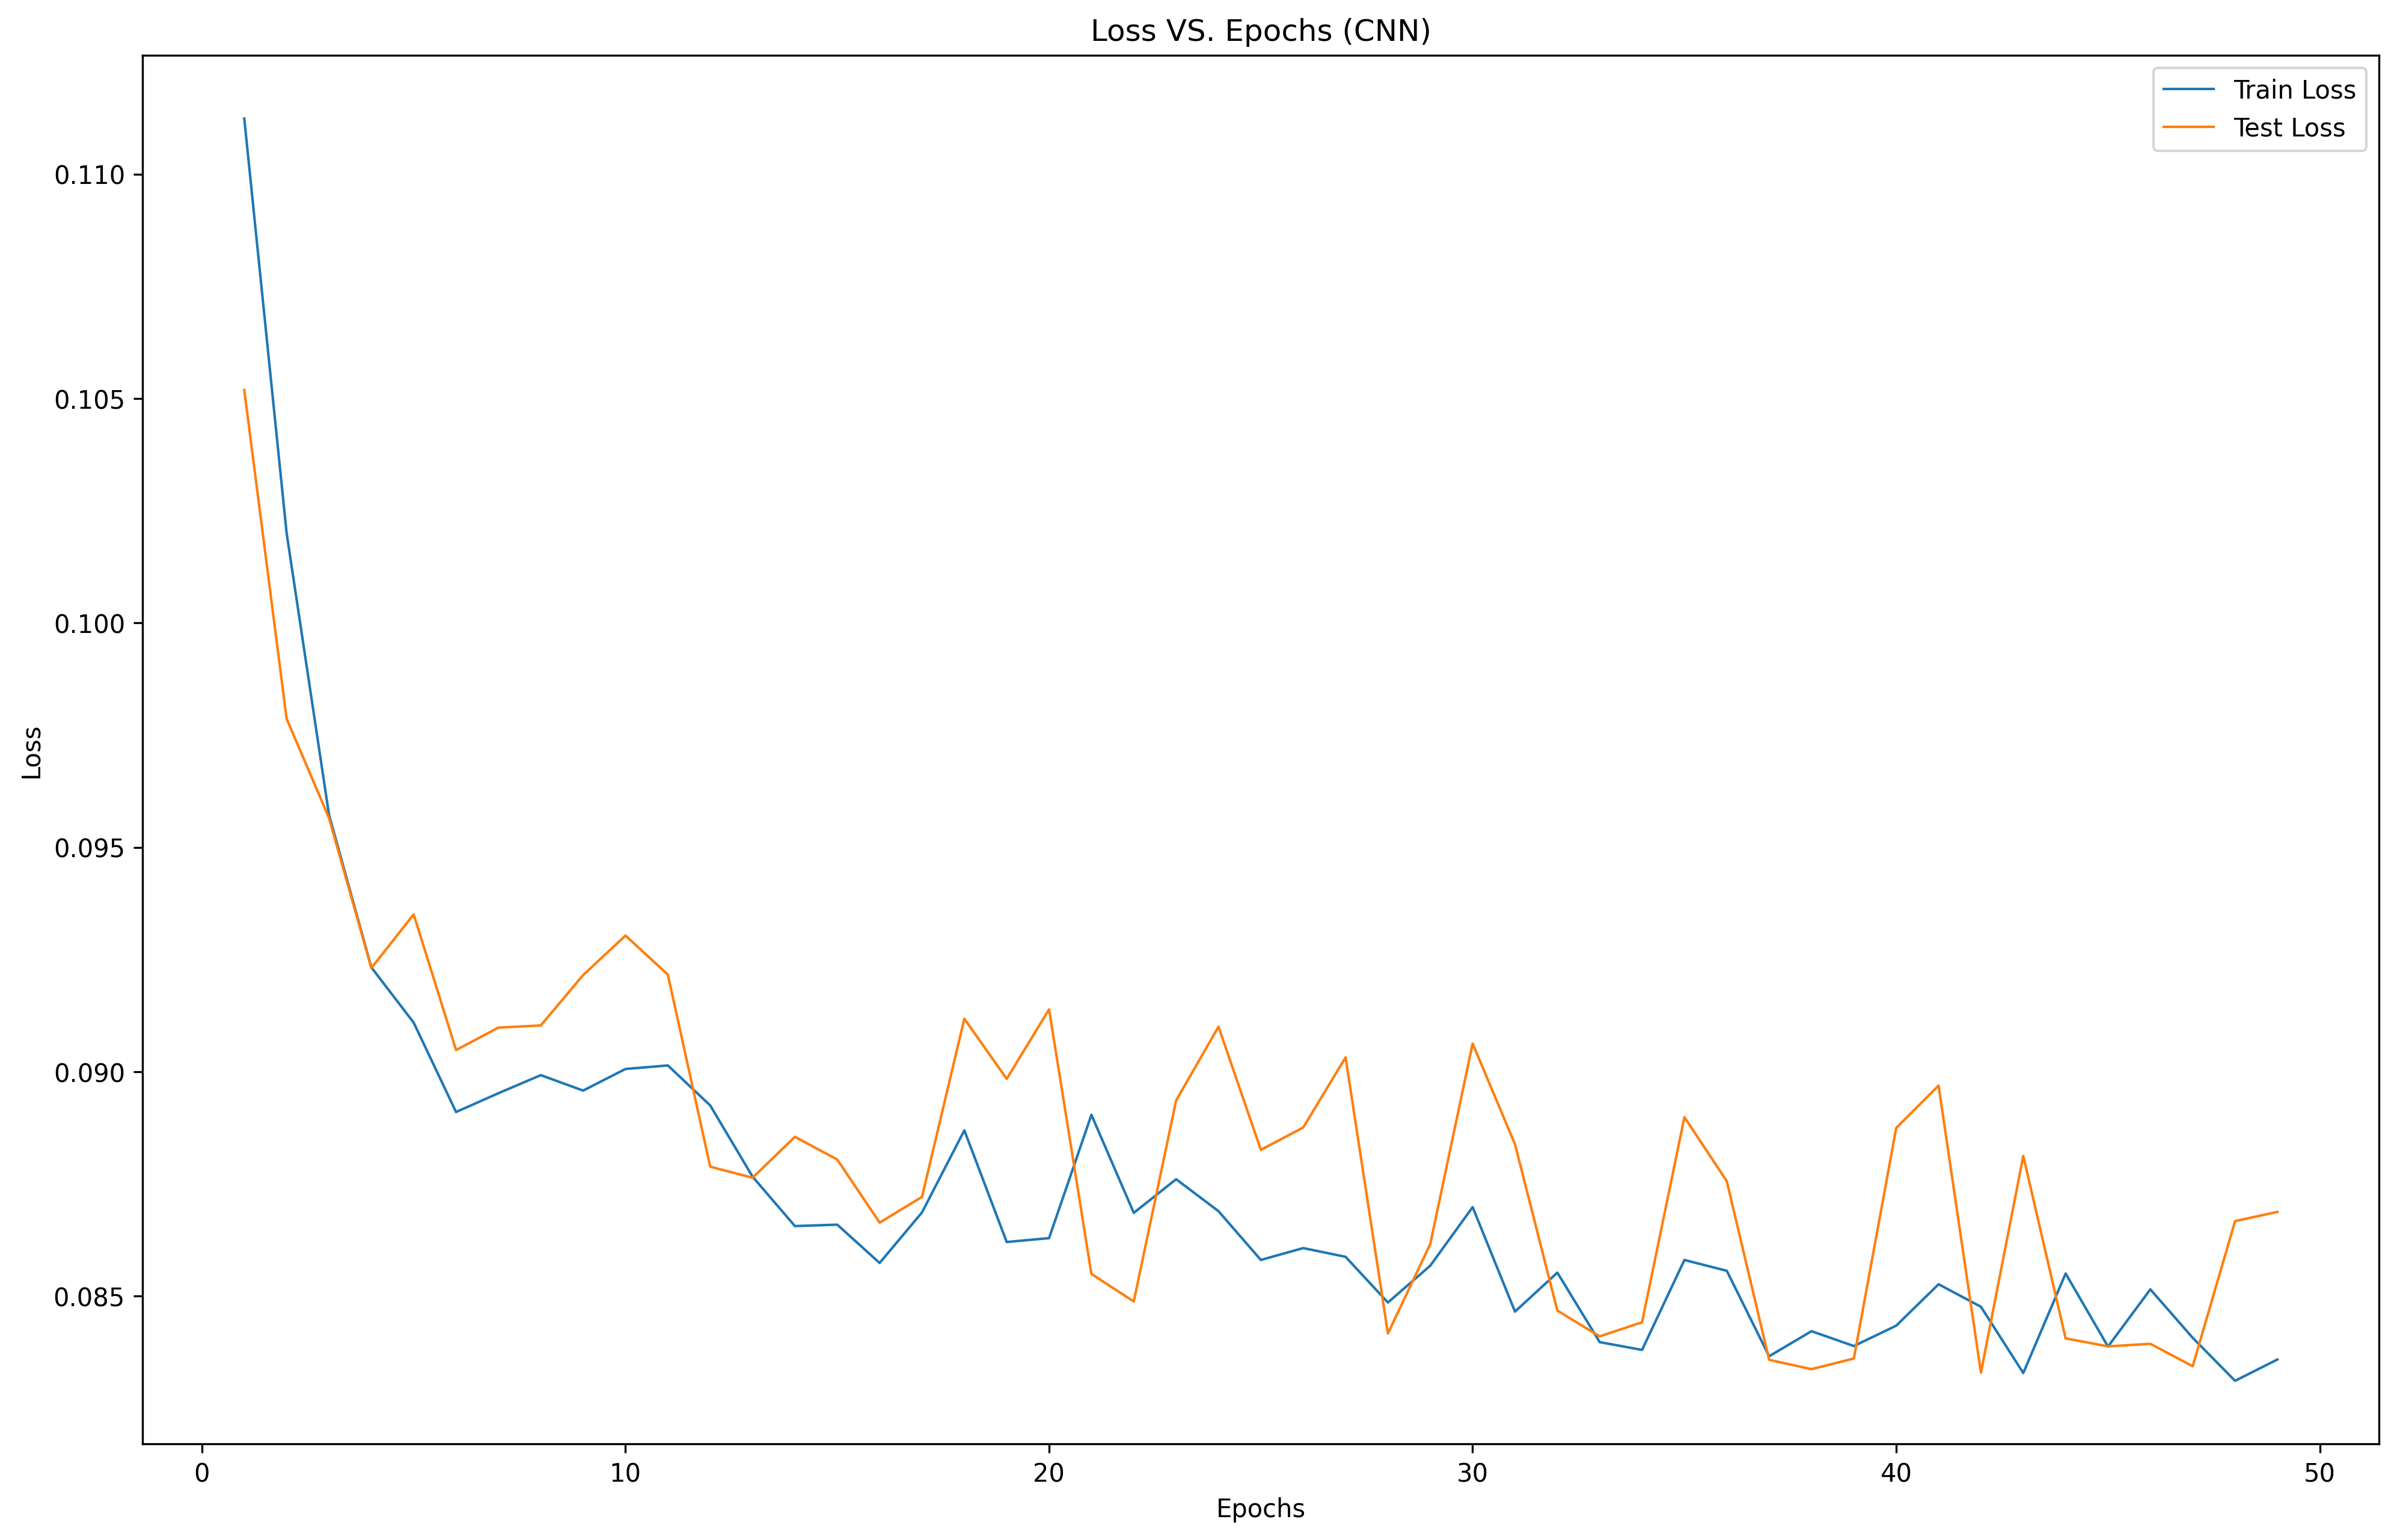

In [21]:
title = "Loss VS. Epochs (CNN)"
plot_eval_results(train_loss_epochs[1:], test_loss_epochs[1:], title)

# Compare CNN with MLP

CNN has smaller loss than MLP since CNN is more suitable for image. CNN can capture the sptial and locality information of an image, which is
not feasible for linear regression.

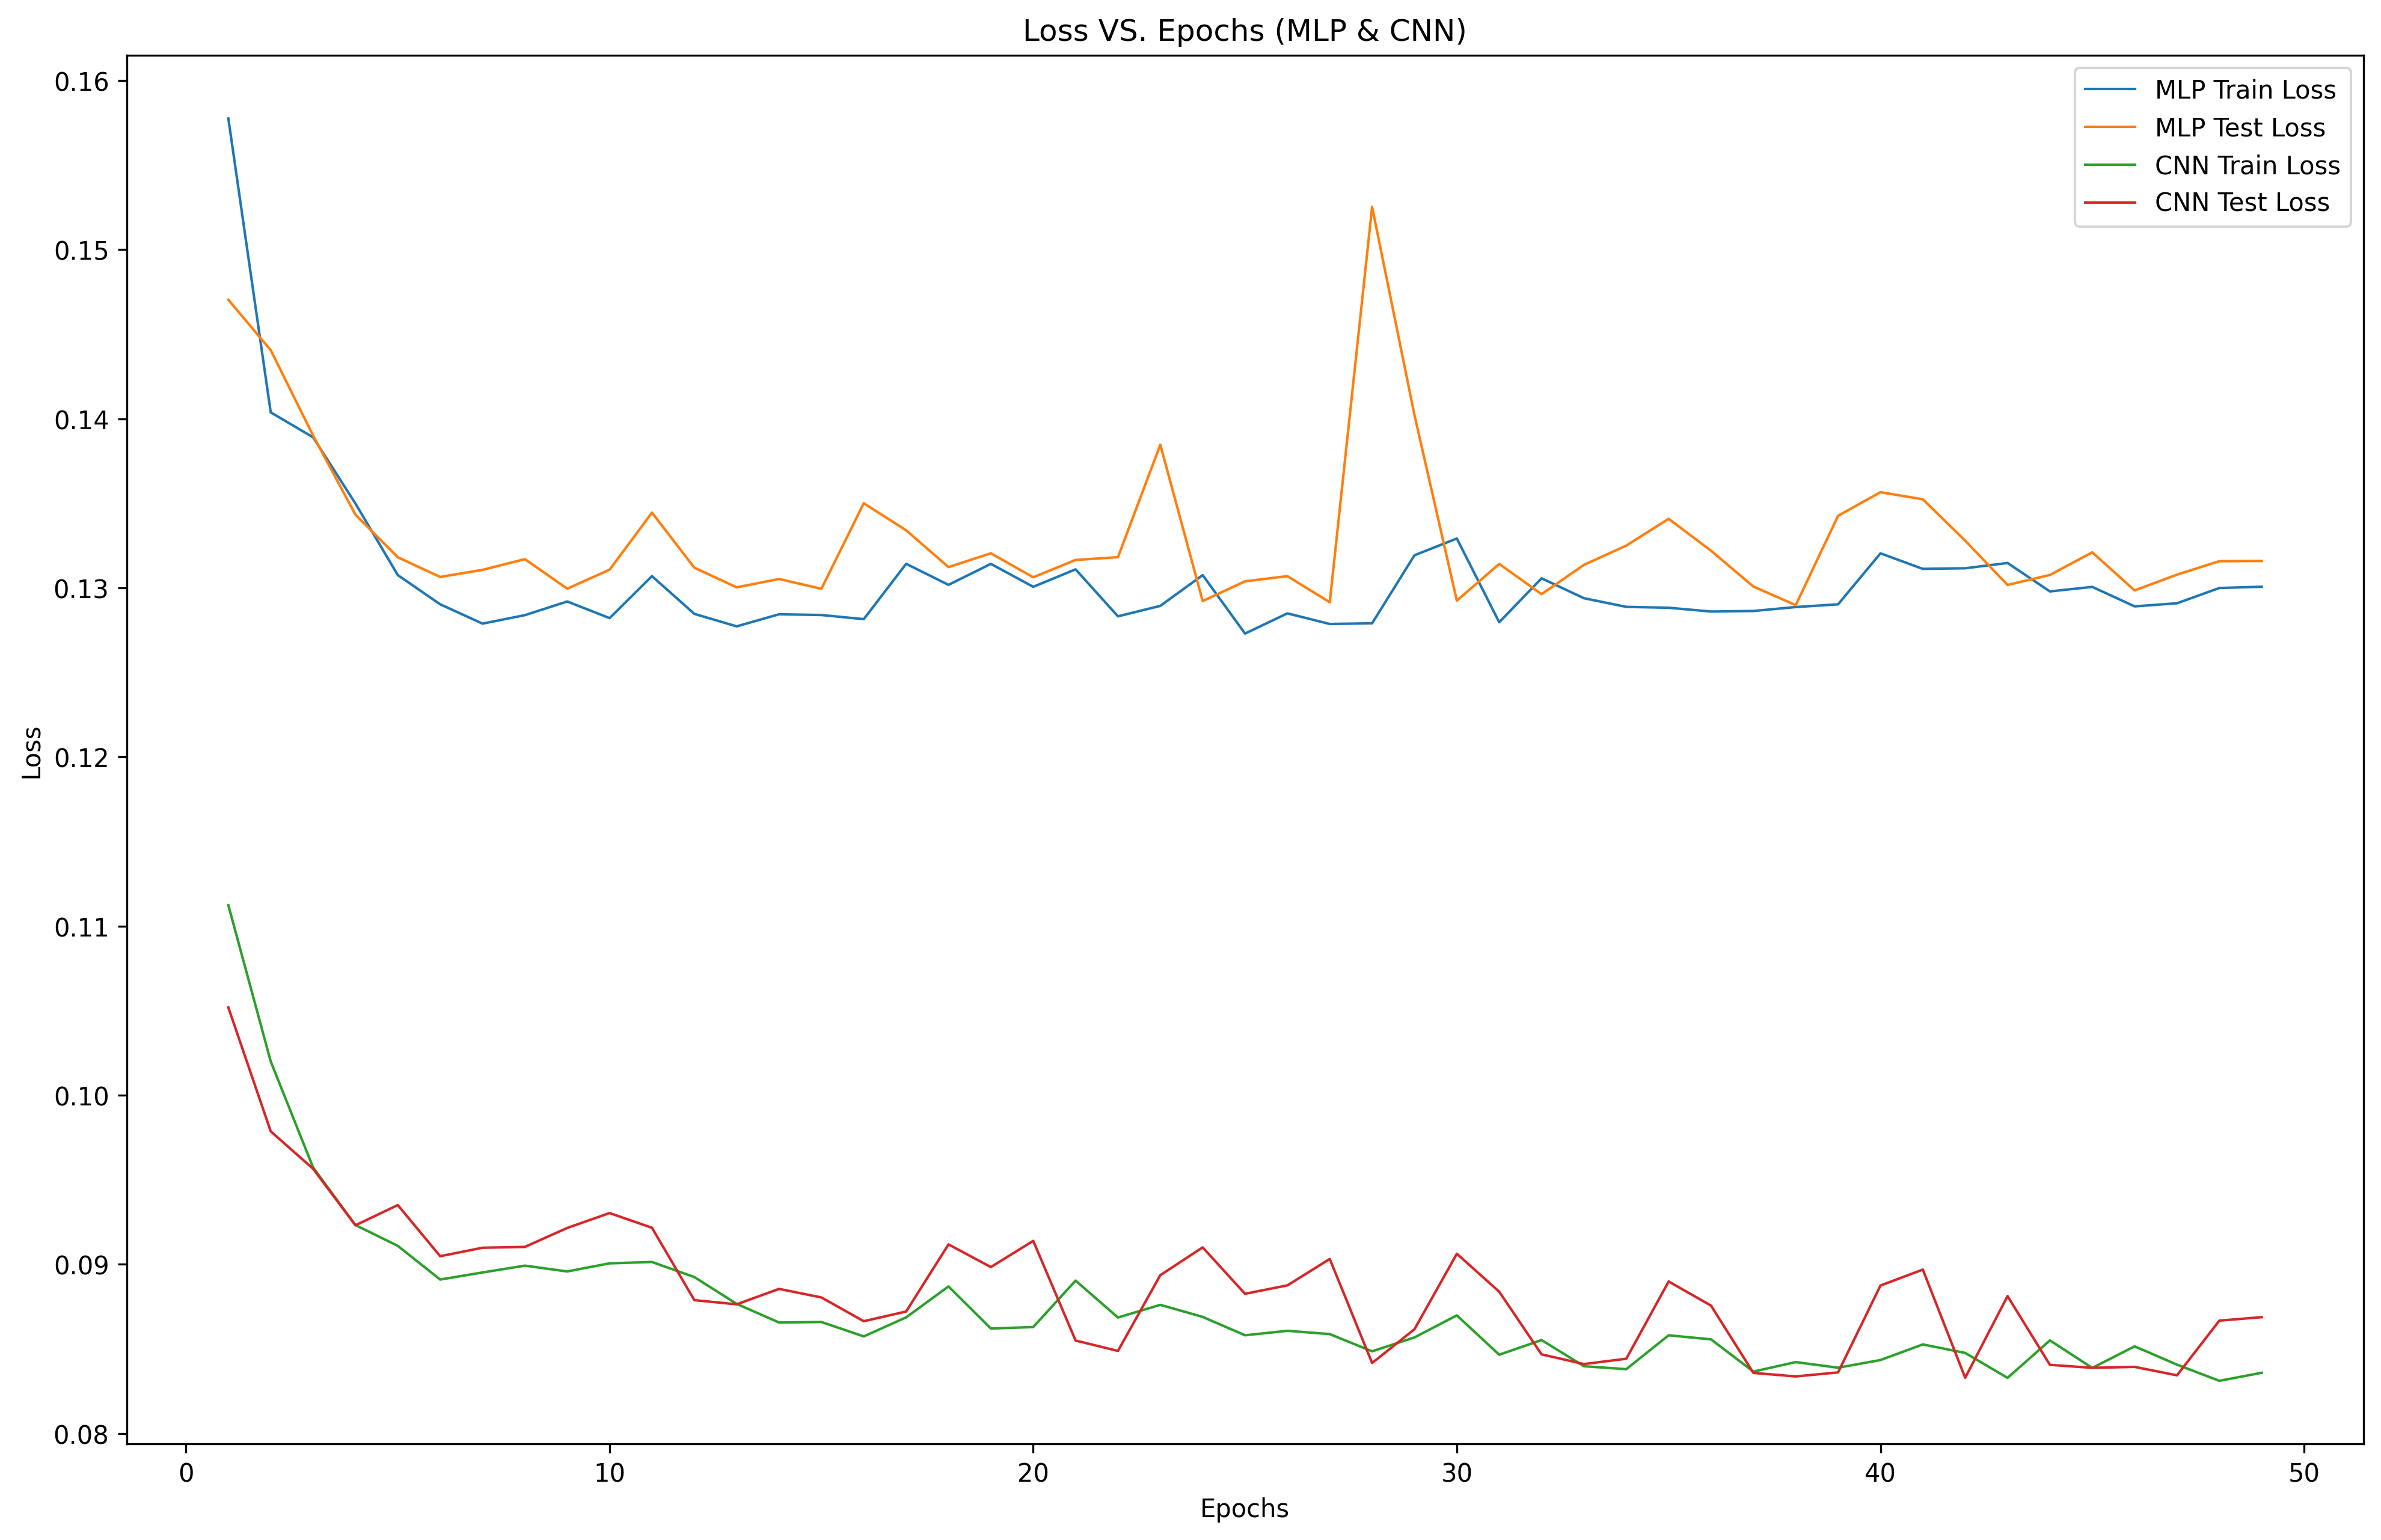

In [22]:
# put four curves in on graph
EPList = [i for i in range(1, EP)]
plt.plot(EPList , MLPTrainLoss[1:], linewidth=1.0 , label = "MLP Train Loss")
plt.plot(EPList , MLPTestLoss[1:], linewidth=1.0 , label = "MLP Test Loss")
plt.plot(EPList , CNNTrainLoss[1:], linewidth=1.0 , label = "CNN Train Loss")
plt.plot(EPList , CNNTestLoss[1:], linewidth=1.0 , label = "CNN Test Loss")
plt.legend()
plt.xlabel("Epochs") ; plt.ylabel("Loss")
plt.title("Loss VS. Epochs (MLP & CNN)")
plt.gcf().set_size_inches(16, 10)
plt.gcf().set_dpi(300)

CNN model parameters

In [23]:
print("My CNN has " + str(getNumberOfParameters(model_task2)) + " parameters")

My CNN has 191 parameters


## Image denoising with vertical and horizontal noise

### Visualizing denoise random noise

Original images:


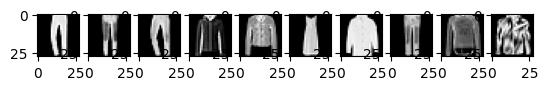

Noisy images:


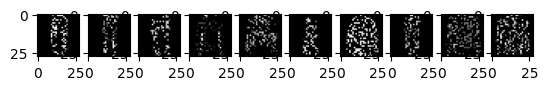

MLP denoised images:


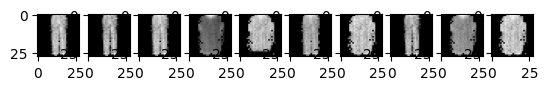

CNN denoised images:


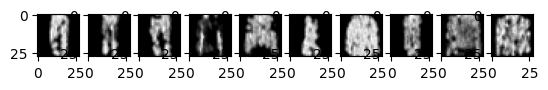

In [24]:
image_batch, noise_image_batch = next(iter(test_loader))
image_batch = image_batch[0]
noise_image_batch = noise_image_batch[0]

print('Original images:')
show_gray_digits(image_batch, 1, 10)
print('Noisy images:')
show_gray_digits(noise_image_batch, 1, 10)
print('MLP denoised images:')
mlp_output = model_task1(noise_image_batch[0:10].to(device))
show_gray_digits(mlp_output, 1, 10)
print('CNN denoised images:')
cnn_output = model_task2(noise_image_batch[0:10].to(device))
show_gray_digits(cnn_output, 1, 10)
plt.show()

### Image reconstruction with vertical and horizontal noises

We want to examine the effectiveness of the neural networks that we trained in the previous parts (MLP and CNN) to denoise some images that are noised with a new type of noise (i.e., vertical and horizontal noise). The noise function is defined as follows:


In [25]:
def add_line_noise(batch_image):
  for i in range(len(batch_image)):
      batch_image[i,0,18:20,:] = 0
      batch_image[i,0,22:26,:] = 0
      batch_image[i,0,:,18:20] = 0
      batch_image[i,0,:,22:26] = 0
  return batch_image

Denoise on the first 10 images in the test set.

Original images:


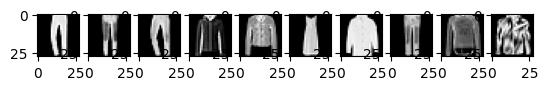

Noisy images:


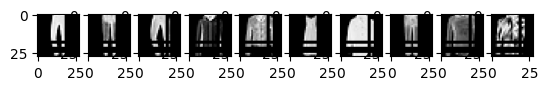

MLP denoised images:


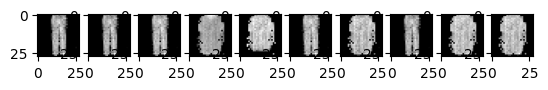

CNN denoised images:


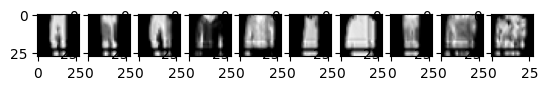

In [26]:
image_batch, noise_image_batch = next(iter(test_loader))
image_batch = image_batch[0]
noise_image_batch = noise_image_batch[0]

print('Original images:')
show_gray_digits(image_batch, 1, 10)

lineNoiseImage = add_line_noise(image_batch)

print('Noisy images:')
show_gray_digits(lineNoiseImage, 1, 10)

print('MLP denoised images:')
mlp_output = model_task1(lineNoiseImage[0:10].to(device))
show_gray_digits(mlp_output, 1, 10)

print('CNN denoised images:')
cnn_output = model_task2(lineNoiseImage[0:10].to(device))
show_gray_digits(cnn_output, 1, 10)

plt.show()

## Image denoising on other classes
Use the trained models from previous tasks and run them on the last 5 classes.

In [27]:
# Import the last 5 classes from MNIST digit dataset
def importMnistDatasetLastFiveClasses(train, transform=[]):
  # it will try to download the dataset if dataset is not found under the root directory
  dataset = torchvision.datasets.FashionMNIST(root='./data', train=train, download=True, transform=transform)
  idx = dataset.targets > 5
  dataset.targets = dataset.targets[idx]
  dataset.data = dataset.data[idx]

  return dataset

In [28]:
# Load test data.
_, test_loader_first5 = load_data(batch_size=64)
_, test_loader_last5 = load_data(batch_size=64, importFunc=importMnistDatasetLastFiveClasses)
print(f'test_loader has {len(test_loader_last5)} batches')

test_loader has 16 batches


In [29]:
#define Loss function
LossFunction = nn.L1Loss()

MLPLoss_first5 = test(test_loader_first5, model_task1, LossFunction)
CNNLoss_first5 = test(test_loader_first5, model_task2, LossFunction)

MLPLoss_last5 = test(test_loader_last5, model_task1, LossFunction)
CNNLoss_last5 = test(test_loader_last5, model_task2, LossFunction)

print("MLP Loss for first 5 classes = ", MLPLoss_first5)
print("CNN Loss for first 5 classes = ", CNNLoss_first5)
print("MLP Loss for last 5 classes = ", MLPLoss_last5)
print("CNN Loss for last 5 classes = ", CNNLoss_last5)

MLP Loss for first 5 classes =  0.13183765765279531
CNN Loss for first 5 classes =  0.08662351360544562
MLP Loss for last 5 classes =  0.2194606140255928
CNN Loss for last 5 classes =  0.08452803734689951
